In [203]:
import pymysql
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pandas.plotting import parallel_coordinates
from sklearn.decomposition import PCA

In [204]:
conn = pymysql.connect(host="127.0.0.1", user="root", password="Vick_nesh@123", database="absenteeism")
cursor = conn.cursor()

In [205]:
# Fetch data from the Reason table
cursor.execute('SELECT * FROM Reason')
reason_data = cursor.fetchall()
reason_df = pd.DataFrame(reason_data, columns=['Reason_ID', 'Reason_For_Absence'])

In [206]:
# Fetch data from the Education table
cursor.execute('SELECT * FROM Education')
education_data = cursor.fetchall()
education_df = pd.DataFrame(education_data, columns=['Education_ID', 'Education_Level'])

In [207]:
# Fetch data from the Days table
cursor.execute('SELECT * FROM Days')
days_data = cursor.fetchall()
days_df = pd.DataFrame(days_data, columns=['Day_Value', 'Day_of_the_week'])


In [208]:
# Fetch data from the Employee table
cursor.execute('SELECT * FROM Employee')
employee_data = cursor.fetchall()
employee_df = pd.DataFrame(employee_data, columns=['Employee_ID', 'Education_ID', 'Transportation_Expense', 'Distance_From_Residence', 'Service_Time', 'Age', 'Son', 'Social_Drinker', 'Social_Smoker', 'Pet', 'Weight', 'Height', 'BMI'])

In [209]:
# Fetch data from the Absenteeism table
cursor.execute('SELECT * FROM Absenteeism')
absenteeism_data = cursor.fetchall()
absenteeism_df = pd.DataFrame(absenteeism_data, columns=['Absence_ID', 'Month_Of_Absence', 'Season', 'Work_Load_Avg', 'Hit_Target', 'Disciplinary_Failure', 'Absence_Time', 'Employee_ID', 'Reason_ID', 'Day_Value'])

In [210]:
# Merge DataFrames
merged_df = pd.merge(absenteeism_df, employee_df, on='Employee_ID')
merged_df = pd.merge(merged_df, reason_df, on='Reason_ID')
merged_df = pd.merge(merged_df, days_df, on='Day_Value')
merged_df = pd.merge(merged_df, education_df, on='Education_ID')

In [161]:
import pandas as pd
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

print(merged_df)


    Absence_ID  Month_Of_Absence  Season  Work_Load_Avg  Hit_Target  \
0       ID-001                 7       1         239554          97   
1       ID-485                 8       1         249797          93   
2       ID-452                 6       3         253957          95   
3       ID-486                 8       1         249797          93   
4       ID-520                10       4         284853          91   
5       ID-027                 8       1         205917          92   
6       ID-260                 8       1         265615          94   
7       ID-231                 6       3         377550          94   
8       ID-663                 4       3         246288          91   
9       ID-043                 9       1         241476          92   
10      ID-047                 9       1         241476          92   
11      ID-063                10       4         253465          93   
12      ID-664                 4       3         246288          91   
13    

In [211]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740 entries, 0 to 739
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Absence_ID               740 non-null    object
 1   Month_Of_Absence         740 non-null    int64 
 2   Season                   740 non-null    int64 
 3   Work_Load_Avg            740 non-null    int64 
 4   Hit_Target               740 non-null    int64 
 5   Disciplinary_Failure     740 non-null    int64 
 6   Absence_Time             740 non-null    int64 
 7   Employee_ID              740 non-null    int64 
 8   Reason_ID                740 non-null    int64 
 9   Day_Value                740 non-null    int64 
 10  Education_ID             740 non-null    int64 
 11  Transportation_Expense   740 non-null    int64 
 12  Distance_From_Residence  740 non-null    int64 
 13  Service_Time             740 non-null    int64 
 14  Age                      740 non-null    i

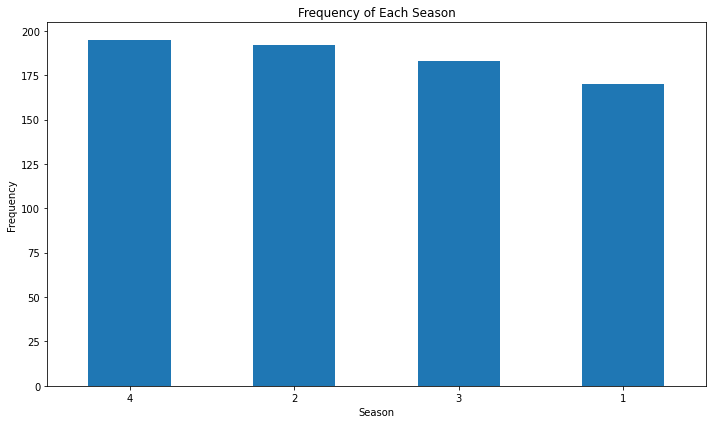

In [212]:
## Calculate the frequency of each Season
season_counts = merged_df['Season'].value_counts()

# Plot the frequency of each Season using a bar plot
plt.figure(figsize=(10, 6))  # Set the figure size
season_counts.plot(kind='bar')  # Plot a bar chart

plt.xlabel('Season')  # Set the x-axis label
plt.ylabel('Frequency')  # Set the y-axis label
plt.title('Frequency of Each Season')  # Set the plot title
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()  # Show the plot

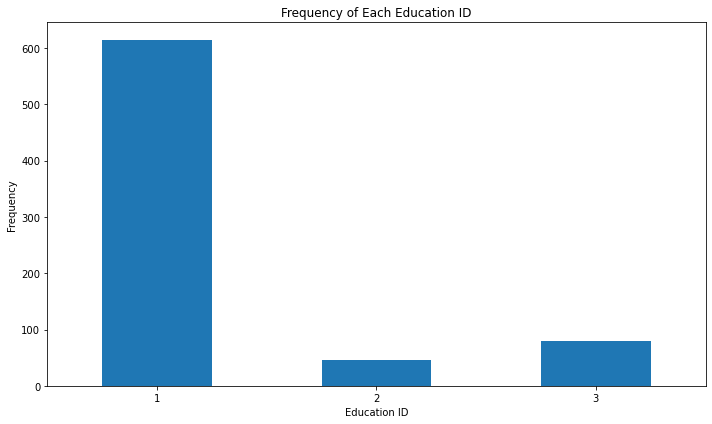

In [213]:
# Calculate the frequency of each Education_ID
education_id_counts = merged_df['Education_ID'].value_counts()

# Get all unique Education IDs in the dataset
unique_education_ids = merged_df['Education_ID'].unique()

# Plot the frequency of each Education ID using a bar plot
plt.figure(figsize=(10, 6)) 
education_id_counts.reindex(unique_education_ids, fill_value=0).plot(kind='bar') 
plt.xlabel('Education ID')  
plt.ylabel('Frequency')  
plt.title('Frequency of Each Education ID')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

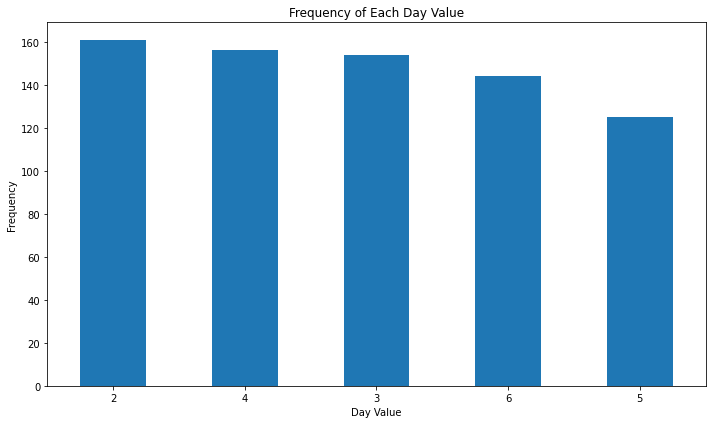

In [214]:
# Calculate the frequency of each Day_Value
day_value_counts = merged_df['Day_Value'].value_counts()


plt.figure(figsize=(10, 6))
day_value_counts.plot(kind='bar') 

plt.xlabel('Day Value')
plt.ylabel('Frequency') 
plt.title('Frequency of Each Day Value') 
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()


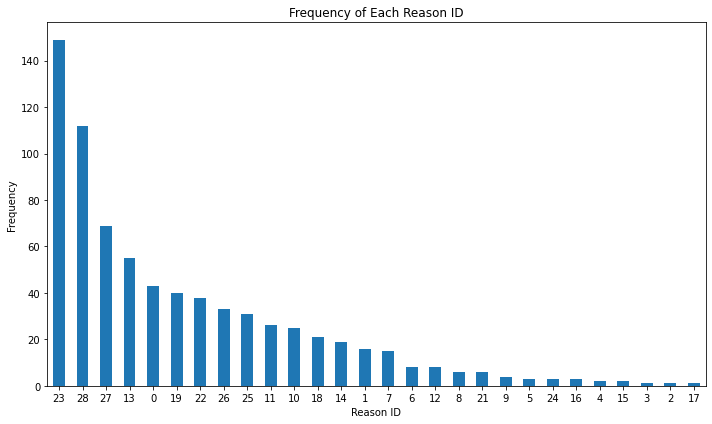

In [215]:
# Calculate the frequency of each Reason_ID
reason_id_counts = merged_df['Reason_ID'].value_counts()

plt.figure(figsize=(10, 6))
reason_id_counts.plot(kind='bar')  

plt.xlabel('Reason ID') 
plt.ylabel('Frequency') 
plt.title('Frequency of Each Reason ID')  
plt.xticks(rotation=0) 
plt.tight_layout() 
plt.show() 

In [217]:
def categorize_reason(row):
    reason = row['Reason_For_Absence'].strip()  # Strip any leading or trailing spaces
    health_related = [
        'Certain infectious and parasitic diseases', 'Neoplasms',
        'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
        'Endocrine, nutritional and metabolic diseases', 'Mental and behavioural disorders',
        'Diseases of the nervous system', 'Diseases of the eye and adnexa',
        'Diseases of the ear and mastoid process', 'Diseases of the circulatory system',
        'Diseases of the respiratory system', 'Diseases of the digestive system',
        'Diseases of the skin and subcutaneous tissue', 'Diseases of the musculoskeletal system and connective tissue',
        'Diseases of the genitourinary system', 'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified'
    ]
    injury_accidents = [
        'Injury, poisoning and certain other consequences of external causes'
    ]
    routine_preventive_care = [
        'Patient follow-up', 'Medical consultation', 'Blood donation',
        'Laboratory examination', 'Physiotherapy', 'Dental consultation',
        'Unjustified absence'  # Adding 'Unjustified absence' here
    ]
    life_events_personal = [
        'Pregnancy, childbirth and the puerperium', 'Certain conditions originating in the perinatal period',
        'Congenital malformations, deformations and chromosomal abnormalities',
        'Factors influencing health status and contact with health services'
    ]
    no_reason = 'No Reason For Absence'
    
    if reason in health_related:
        return 'Health-Related Absences'
    elif reason in injury_accidents:
        return 'Injury and Accidents'
    elif reason in routine_preventive_care:
        return 'Routine and Preventive Care'
    elif reason in life_events_personal:
        return 'Life Events and Personal Circumstances'
    elif reason == no_reason:
        return 'No Recorded Reason'
    else:
        return 'Other'  # Fallback, if any new reasons are added later

# Apply the categorization function to the dataset
merged_df['Reason_Category'] = merged_df.apply(categorize_reason, axis=1)

# Check the distribution of the new categorical reasons
print(merged_df['Reason_Category'].value_counts())


Routine and Preventive Care               435
Health-Related Absences                   210
No Recorded Reason                         43
Injury and Accidents                       40
Life Events and Personal Circumstances     12
Name: Reason_Category, dtype: int64


In [218]:
#Looking for missing values
merged_df.head()
merged_df.isnull().sum()

Absence_ID                 0
Month_Of_Absence           0
Season                     0
Work_Load_Avg              0
Hit_Target                 0
Disciplinary_Failure       0
Absence_Time               0
Employee_ID                0
Reason_ID                  0
Day_Value                  0
Education_ID               0
Transportation_Expense     0
Distance_From_Residence    0
Service_Time               0
Age                        0
Son                        0
Social_Drinker             0
Social_Smoker              0
Pet                        0
Weight                     0
Height                     0
BMI                        0
Reason_For_Absence         0
Day_of_the_week            0
Education_Level            0
Reason_Category            0
dtype: int64

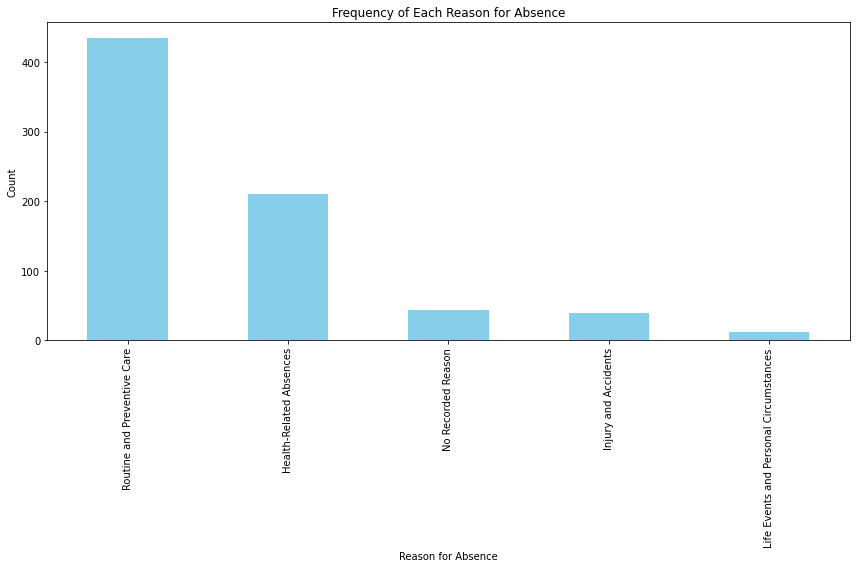

In [219]:


plt.figure(figsize=(12, 8))
merged_df['Reason_Category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Reason for Absence')
plt.xlabel('Reason for Absence')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


<Figure size 1008x504 with 0 Axes>

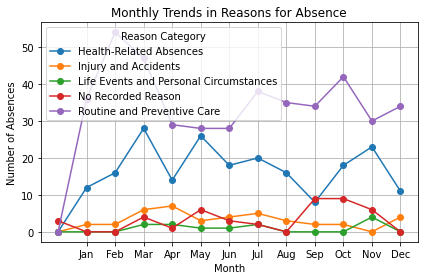

In [220]:
plt.figure(figsize=(14, 7))
monthly_trends = merged_df.groupby(['Month_Of_Absence', 'Reason_Category']).size().unstack().fillna(0)
monthly_trends.plot(kind='line', marker='o')
plt.title('Monthly Trends in Reasons for Absence')
plt.xlabel('Month')
plt.ylabel('Number of Absences')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Reason Category')
plt.grid(True)
plt.tight_layout()
plt.show()


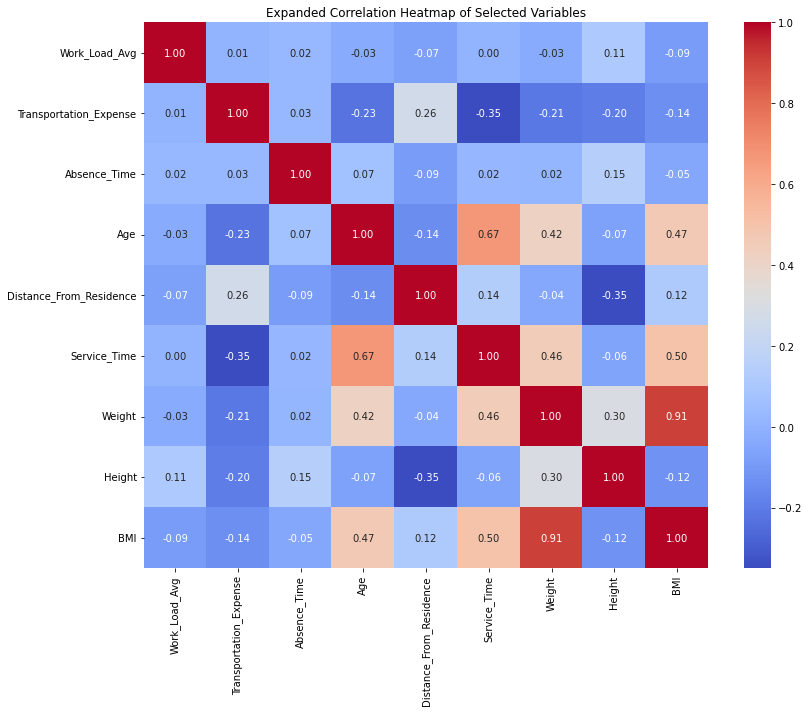

In [221]:
expanded_numeric_vars = ['Work_Load_Avg', 'Transportation_Expense', 'Absence_Time', 'Age', 'Distance_From_Residence', 'Service_Time', 'Weight', 'Height', 'BMI']
plt.figure(figsize=(12, 10))
sns.heatmap(merged_df[expanded_numeric_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Expanded Correlation Heatmap of Selected Variables')
plt.tight_layout()
plt.show()



In [222]:
#Testing relationship between 'Education_Level' and 'Reason_Category'
contingency_table = pd.crosstab(merged_df['Education_Level'], merged_df['Reason_Category'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test")
print("Chi2 Stat:", chi2)
print("P-value:", p)


Chi-Square Test
Chi2 Stat: 47.588524180866855
P-value: 1.1840130478343195e-07


In [223]:
contingency_table = pd.crosstab(merged_df['Education_Level'], merged_df['Reason_Category'])

# Performing the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Convering the expected frequencies into a DataFrame for easier comparison
expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)

# Printing observed and expected frequencies
print("Observed Frequencies:\n", contingency_table)
print("\nExpected Frequencies:\n", expected_df)


Observed Frequencies:
 Reason_Category  Health-Related Absences  Injury and Accidents  \
Education_Level                                                  
Graduate                              19                     3   
High School                          161                    36   
PostGraduate                          30                     1   

Reason_Category  Life Events and Personal Circumstances  No Recorded Reason  \
Education_Level                                                               
Graduate                                              5                   3   
High School                                           4                  39   
PostGraduate                                          3                   1   

Reason_Category  Routine and Preventive Care  
Education_Level                               
Graduate                                  16  
High School                              375  
PostGraduate                              44  

Expected Frequ

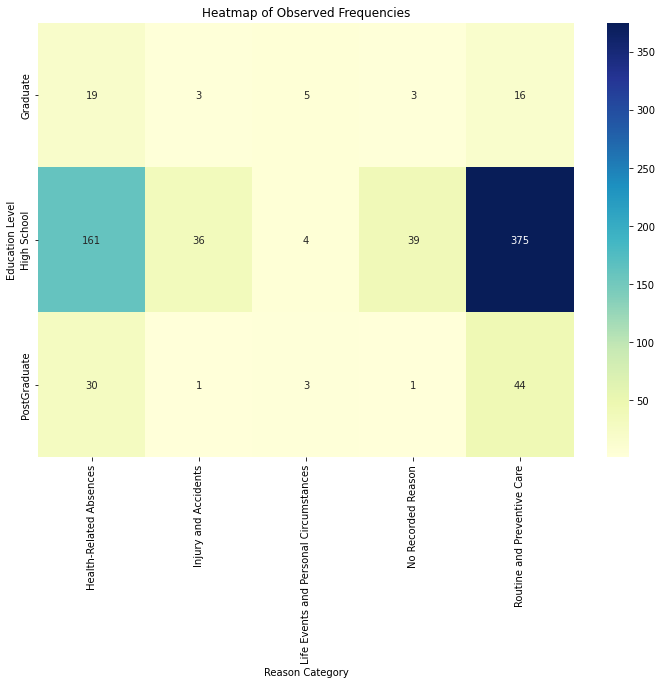

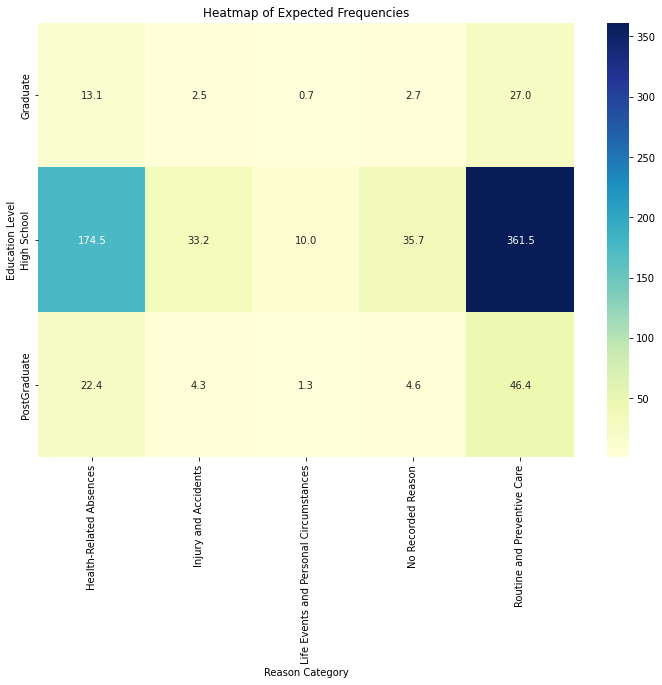

In [224]:
# Heatmap for observed frequencies
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Heatmap of Observed Frequencies')
plt.ylabel('Education Level')
plt.xlabel('Reason Category')
plt.show()

# Heatmap for expected frequencies
plt.figure(figsize=(12, 8))
sns.heatmap(expected_df, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Heatmap of Expected Frequencies')
plt.ylabel('Education Level')
plt.xlabel('Reason Category')
plt.show()


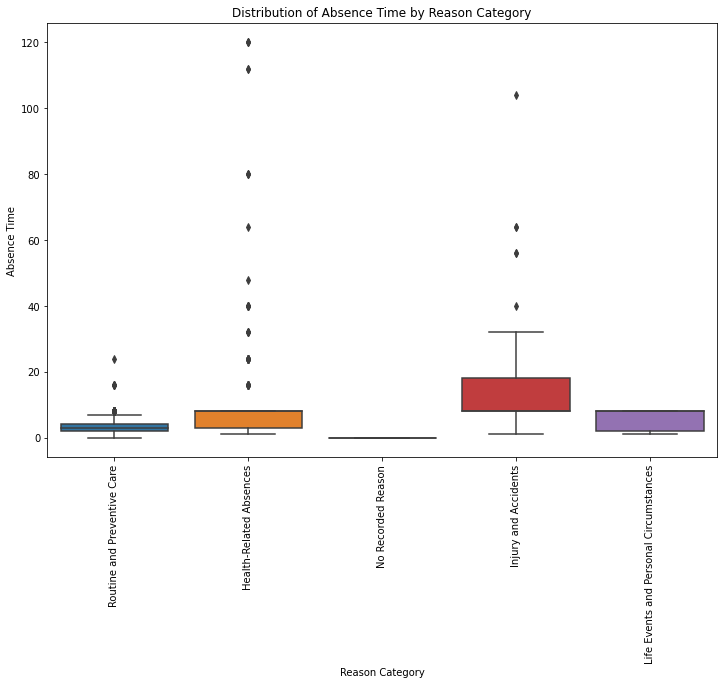

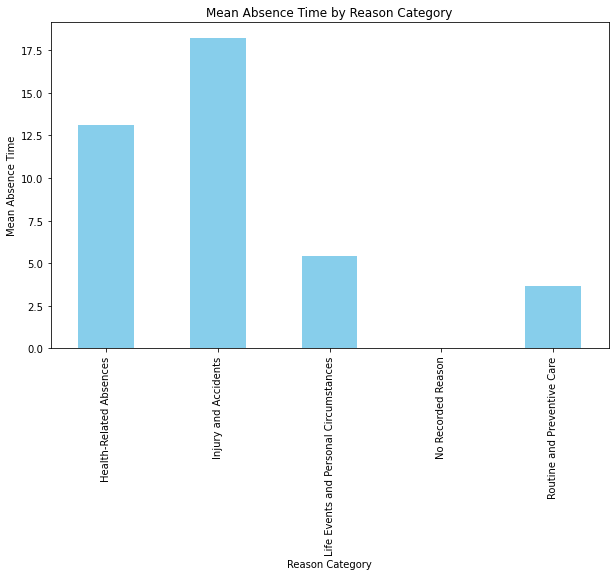

Descriptive Statistics by Reason Category:
                                              mean  median        std
Reason_Category                                                     
Health-Related Absences                 13.090476       8  20.589550
Injury and Accidents                    18.225000       8  22.117968
Life Events and Personal Circumstances   5.416667       8   3.232177
No Recorded Reason                       0.000000       0   0.000000
Routine and Preventive Care              3.634483       3   2.898785

Kruskal-Wallis Test Results -- Statistic: 267.94, P-value: 0.0000


In [225]:
# Calculate descriptive statistics for each reason category
grouped_data = merged_df.groupby('Reason_Category')['Absence_Time'].agg(['mean', 'median', 'std'])

# Perform Kruskal-Wallis Test if data is not normally distributed
stat, p = kruskal(*[group['Absence_Time'] for name, group in merged_df.groupby('Reason_Category')])

# Visualization
# Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Reason_Category', y='Absence_Time', data=merged_df)
plt.title('Distribution of Absence Time by Reason Category')
plt.xlabel('Reason Category')
plt.ylabel('Absence Time')
plt.xticks(rotation=90)
plt.show()

# Bar Graph of Means
plt.figure(figsize=(10, 6))
grouped_data['mean'].plot(kind='bar', color='skyblue')
plt.title('Mean Absence Time by Reason Category')
plt.xlabel('Reason Category')
plt.ylabel('Mean Absence Time')
plt.xticks(rotation=90)
plt.show()

print("Descriptive Statistics by Reason Category:\n", grouped_data)
print("\nKruskal-Wallis Test Results -- Statistic: {:.2f}, P-value: {:.4f}".format(stat, p))


In [226]:
# Define categories of interest
categories_of_interest = ['Health-Related Absences', 'Injury and Accidents']

# Filter data for these categories
filtered_data = merged_df[merged_df['Reason_Category'].isin(categories_of_interest)]

# Calculate mean and standard deviation for Absence Time in these categories
category_stats = filtered_data.groupby('Reason_Category')['Absence_Time'].agg(['mean', 'std']).reset_index()

# Define a high absence threshold (mean + 2*std)
category_stats['high_absence_threshold'] = category_stats['mean'] + 2 * category_stats['std']

# Merge back to get the threshold per category in the main DataFrame
filtered_data = filtered_data.merge(category_stats[['Reason_Category', 'high_absence_threshold']], on='Reason_Category')

# Identify outliers
outliers = filtered_data[filtered_data['Absence_Time'] > filtered_data['high_absence_threshold']]

# Analyze common characteristics of outliers focusing on available attributes
outliers_summary = outliers.groupby(['Reason_Category', 'Age', 'Transportation_Expense', 'Distance_From_Residence'])['Absence_Time'].size().reset_index(name='Count')

print(outliers_summary)



           Reason_Category  Age  Transportation_Expense  \
0  Health-Related Absences   28                     225   
1  Health-Related Absences   30                     179   
2  Health-Related Absences   31                     369   
3  Health-Related Absences   34                     155   
4  Health-Related Absences   50                     118   
5  Health-Related Absences   58                     228   
6     Injury and Accidents   33                     289   
7     Injury and Accidents   37                     118   
8     Injury and Accidents   43                     300   

   Distance_From_Residence  Count  
0                       26      1  
1                       26      1  
2                       17      1  
3                       12      2  
4                       13      2  
5                       14      2  
6                       36      1  
7                       10      1  
8                       26      1  


                                       Features  Importance
2                                 Work_Load_Avg    0.142356
10                                          Age    0.135008
5                                     Day_Value    0.109164
0                              Month_Of_Absence    0.098222
21  Reason_Category_Routine and Preventive Care    0.081165
1                                        Season    0.075596
3                                    Hit_Target    0.058974
16                                       Height    0.057852
18         Reason_Category_Injury and Accidents    0.050513
7                        Transportation_Expense    0.045195


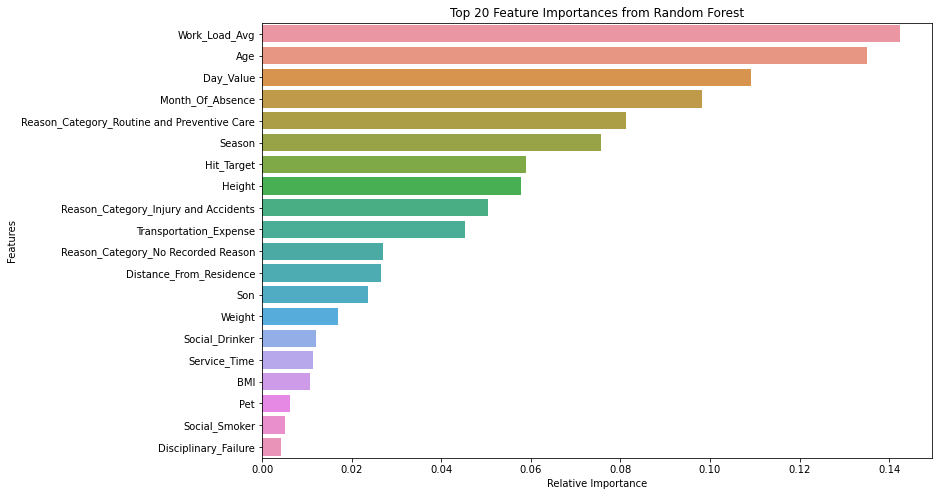

In [227]:
if 'Reason_Category' in merged_df.select_dtypes(include=['object']).columns:
    merged_df = pd.get_dummies(merged_df, columns=['Reason_Category'], drop_first=True)

# Define features and target
X = merged_df.drop(['Absence_Time', 'Reason_For_Absence', 'Day_of_the_week', 'Education_Level','Absence_ID','Reason_ID','Employee_ID'], axis=1)  # Exclude target and original categorical columns
y = merged_df['Absence_Time']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importance
importances = rf.feature_importances_
feature_names = X_train.columns
importance_frame = pd.DataFrame({'Features': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Display the top 20 most important features
print(importance_frame.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Features', data=importance_frame.head(20), orient='h')
plt.title('Top 20 Feature Importances from Random Forest')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()



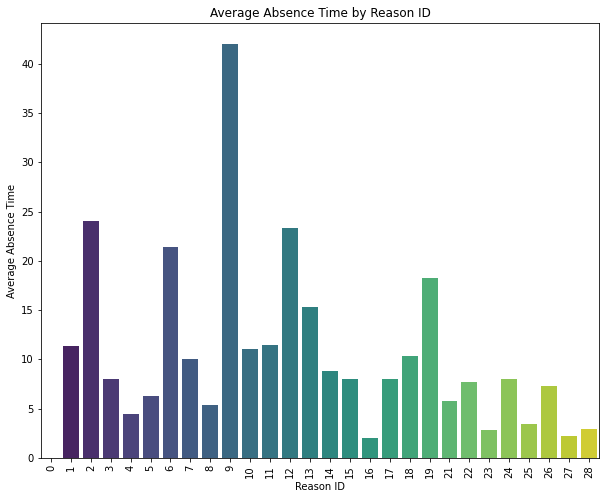

In [228]:
# Grouping data to see the average absence time by Reason_ID
avg_absence_by_reason = merged_df.groupby('Reason_ID')['Absence_Time'].mean().sort_values(ascending=False)

# Plotting the results
plt.figure(figsize=(10, 8))
sns.barplot(x=avg_absence_by_reason.index, y=avg_absence_by_reason.values, palette="viridis")
plt.title('Average Absence Time by Reason ID')
plt.xlabel('Reason ID')
plt.ylabel('Average Absence Time')
plt.xticks(rotation=90)
plt.show()


In [229]:
merged_df = pd.get_dummies(merged_df, columns=['Season'], prefix='Season', drop_first=True)

In [230]:
# One-hot encode the 'Education_ID' column in 'merged_df', dropping the first category
merged_df = pd.get_dummies(merged_df, columns=['Education_ID'], prefix='Education', drop_first=True)

In [231]:
# One-hot encode the 'Day_Value' column in 'merged_df', dropping the first category
merged_df = pd.get_dummies(merged_df, columns=['Day_Value'], prefix='Day', drop_first=True)


In [232]:
merged_df.head()

,Absence_ID,Month_Of_Absence,Work_Load_Avg,Hit_Target,Disciplinary_Failure,Absence_Time,Employee_ID,Reason_ID,Transportation_Expense,Distance_From_Residence,Service_Time,Age,Son,Social_Drinker,Social_Smoker,Pet,Weight,Height,BMI,Reason_For_Absence,Day_of_the_week,Education_Level,Reason_Category_Injury and Accidents,Reason_Category_Life Events and Personal Circumstances,Reason_Category_No Recorded Reason,Reason_Category_Routine and Preventive Care,Season_2,Season_3,Season_4,Education_2,Education_3,Day_3,Day_4,Day_5,Day_6
0,ID-001,7,239554,97,0,4,11,26,289,36,13,33,2,1,0,1,90,172,30,Unjustified absence,Tuesday,High School,0,0,0,1,0,0,0,0,0,1,0,0,0
1,ID-485,8,249797,93,0,8,11,26,289,36,13,33,2,1,0,1,90,172,30,Unjustified absence,Tuesday,High School,0,0,0,1,0,0,0,0,0,1,0,0,0
2,ID-452,6,253957,95,0,8,5,26,235,20,13,43,1,1,0,0,106,167,38,Unjustified absence,Tuesday,High School,0,0,0,1,0,1,0,0,0,1,0,0,0
3,ID-486,8,249797,93,0,8,5,26,235,20,13,43,1,1,0,0,106,167,38,Unjustified absence,Tuesday,High School,0,0,0,1,0,0,0,0,0,1,0,0,0
4,ID-520,10,284853,91,0,8,13,26,369,17,12,31,3,1,0,0,70,169,25,Unjustified absence,Tuesday,High School,0,0,0,1,0,0,1,0,0,1,0,0,0


In [233]:
columns_to_standardize = [
    'Work_Load_Avg', 'Hit_Target', 'Transportation_Expense', 
    'Distance_From_Residence', 'Service_Time', 'Age', 'Weight', 
    'Height', 'BMI'
]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
merged_df[columns_to_standardize] = scaler.fit_transform(merged_df[columns_to_standardize])

print(merged_df.head())


  Absence_ID  Month_Of_Absence  Work_Load_Avg  Hit_Target  \
0     ID-001                 7      -0.818212    0.638686   
1     ID-485                 8      -0.555785   -0.420423   
2     ID-452                 6      -0.449205    0.109131   
3     ID-486                 8      -0.555785   -0.420423   
4     ID-520                10       0.342357   -0.949978   

   Disciplinary_Failure  Absence_Time  Employee_ID  Reason_ID  \
0                     0             4           11         26   
1                     0             8           11         26   
2                     0             8            5         26   
3                     0             8            5         26   
4                     0             8           13         26   

   Transportation_Expense  Distance_From_Residence  Service_Time       Age  \
0                1.011408                 0.426604      0.109072 -0.520347   
1                1.011408                 0.426604      0.109072 -0.520347   
2       

In [252]:
# List of all features to be included in clustering
features = ['Work_Load_Avg', 'Transportation_Expense', 'Distance_From_Residence', 'Service_Time', 'Age', 'Weight', 'Height',
            'Reason_Category_Injury and Accidents', 'Reason_Category_Life Events and Personal Circumstances',
            'Reason_Category_No Recorded Reason', 'Reason_Category_Routine and Preventive Care','Hit_Target',
            'Season_2', 'Season_3', 'Season_4', 'Education_2', 'Education_3',
          'Day_3', 'Day_4', 'Day_5', 'Day_6']

# Apply K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
merged_df['Cluster'] = kmeans.fit_predict(merged_df[features])

# Analyzing the clusters - display the count of data points in each cluster
cluster_counts = merged_df['Cluster'].value_counts()
print(cluster_counts)

# Optionally, inspect the cluster characteristics
cluster_means = merged_df.groupby('Cluster').mean()
print(cluster_means)



1    377
0    363
Name: Cluster, dtype: int64
         Month_Of_Absence  Work_Load_Avg  Hit_Target  Disciplinary_Failure  \
Cluster                                                                      
0                6.573003       0.044518   -0.025810              0.060606   
1                6.084881      -0.042865    0.024852              0.047745   

         Absence_Time  Employee_ID  Reason_ID  Transportation_Expense  \
Cluster                                                                 
0            6.696970      19.4573  18.865014                0.587194   
1            7.143236      16.6313  19.554377               -0.565388   

         Distance_From_Residence  Service_Time       Age       Son  \
Cluster                                                              
0                       0.158758     -0.703074 -0.678974  1.338843   
1                      -0.152862      0.676965  0.653760  0.700265   

         Social_Drinker  Social_Smoker       Pet    Weight    Heigh

In [259]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Load and preprocess your dataset
# merged_df = pd.read_csv('your_dataset.csv')  # Uncomment and modify this if needed

# Standardizing the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(merged_df.select_dtypes(include=[np.number]))

# Applying PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization and clustering
features_pca = pca.fit_transform(features_scaled)

# Perform Agglomerative Hierarchical Clustering with 3 clusters on PCA-reduced data
hierarchical = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster_labels = hierarchical.fit_predict(features_pca)

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(features_pca, cluster_labels)

print(f"Silhouette Score after PCA: {silhouette_avg}")







Silhouette Score after PCA: 0.46708639208975117


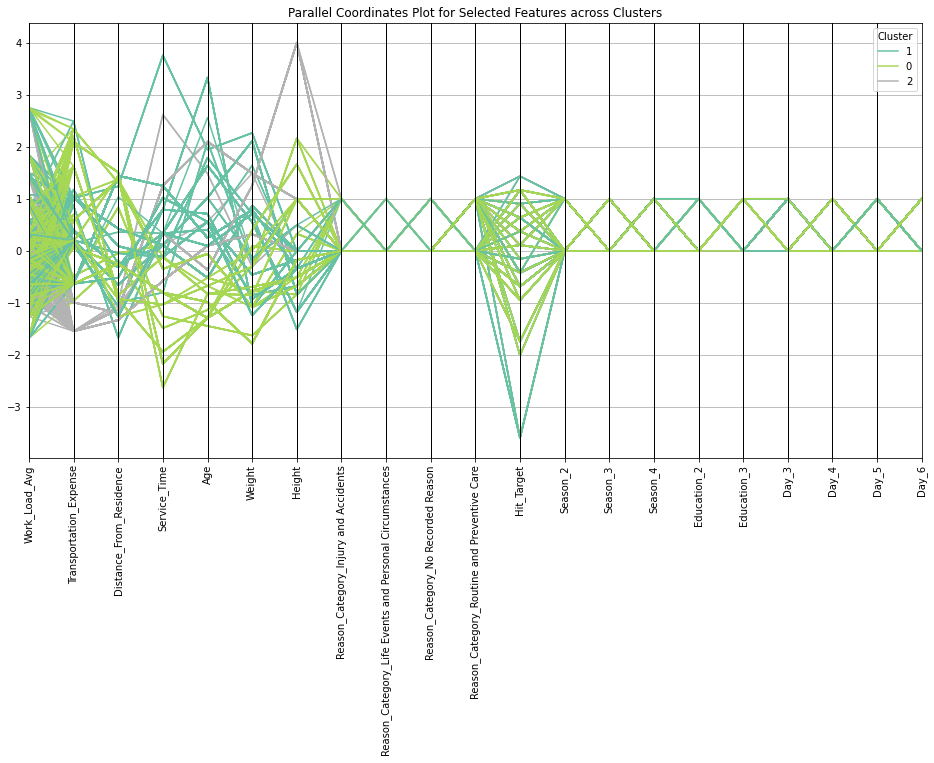

In [235]:
# Define the focused subset of features
focused_features = [
    'Work_Load_Avg', 'Transportation_Expense', 'Distance_From_Residence', 'Service_Time', 'Age', 'Weight', 'Height',
    'Reason_Category_Injury and Accidents', 'Reason_Category_Life Events and Personal Circumstances',
    'Reason_Category_No Recorded Reason', 'Reason_Category_Routine and Preventive Care','Hit_Target',
    'Season_2', 'Season_3', 'Season_4', 'Education_2', 'Education_3', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Cluster'
]

# Create the DataFrame with the selected features
focused_df = merged_df[focused_features]

# Create parallel coordinates plot with the focused features
plt.figure(figsize=(16, 8))
parallel_coordinates(focused_df, 'Cluster', colormap=plt.get_cmap("Set2"))
plt.title('Parallel Coordinates Plot for Selected Features across Clusters')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(title='Cluster')
plt.show()



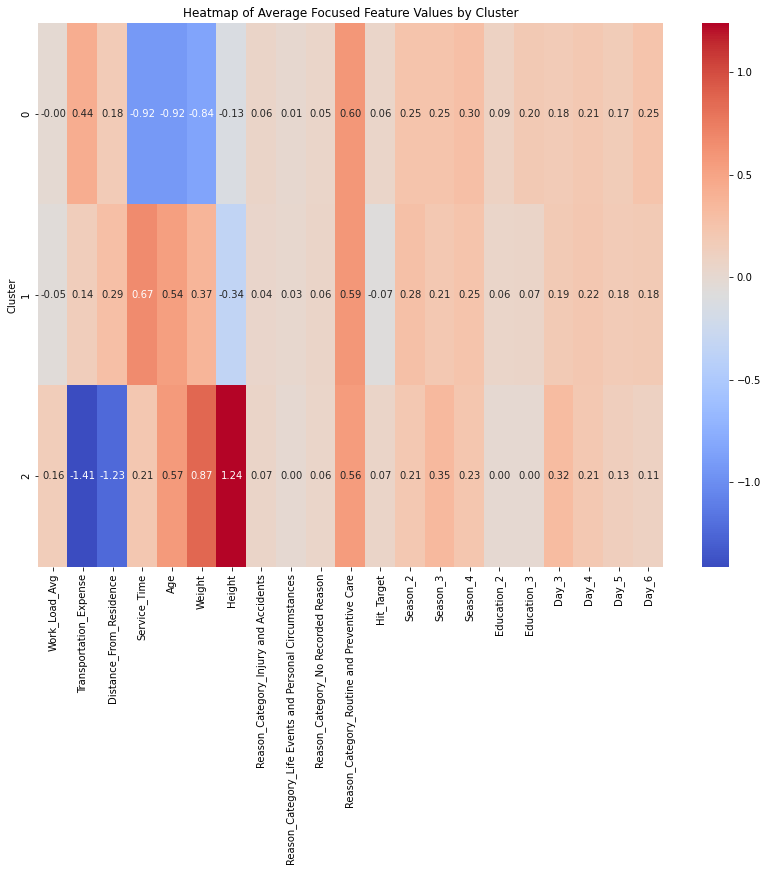

In [236]:
import seaborn as sns

# Calculate the mean of focused features for each cluster
focused_cluster_means = focused_df.groupby('Cluster').mean()

# Create a heatmap of the average feature values by cluster using the focused features
plt.figure(figsize=(14, 10))
sns.heatmap(focused_cluster_means, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Average Focused Feature Values by Cluster')
plt.xticks(rotation=90)
plt.show()

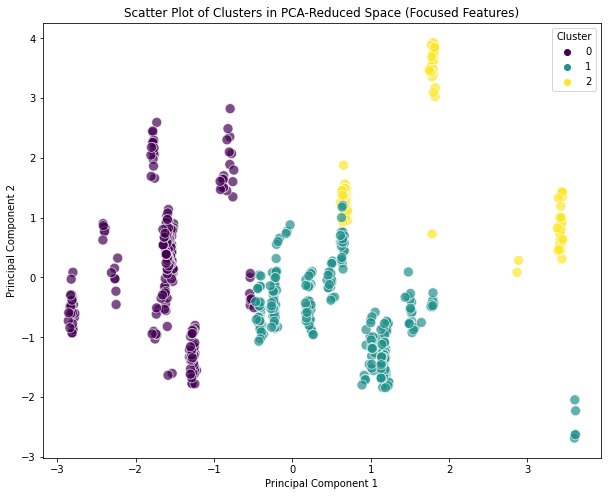

In [237]:
numerical_features_focused = focused_df.select_dtypes(include=[np.number]).columns.drop('Cluster')
X_focused = focused_df[numerical_features_focused]

# Initialize PCA and reduce dimensions to 2 for the focused subset
pca_focused = PCA(n_components=2)
X_pca_focused = pca_focused.fit_transform(X_focused)

# Add the PCA components to a DataFrame for the focused subset
pca_focused_df = pd.DataFrame(data=X_pca_focused, columns=['Principal Component 1', 'Principal Component 2'])
pca_focused_df['Cluster'] = focused_df['Cluster']

# Create scatter plot for the focused subset
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster', data=pca_focused_df, palette='viridis', s=100, alpha=0.7)
plt.title('Scatter Plot of Clusters in PCA-Reduced Space (Focused Features)')
plt.legend(title='Cluster')
plt.show()


In [246]:
merged_df.head()

,Absence_ID,Month_Of_Absence,Work_Load_Avg,Hit_Target,Disciplinary_Failure,Absence_Time,Employee_ID,Reason_ID,Transportation_Expense,Distance_From_Residence,Service_Time,Age,Son,Social_Drinker,Social_Smoker,Pet,Weight,Height,BMI,Reason_For_Absence,Day_of_the_week,Education_Level,Reason_Category_Injury and Accidents,Reason_Category_Life Events and Personal Circumstances,Reason_Category_No Recorded Reason,Reason_Category_Routine and Preventive Care,Season_2,Season_3,Season_4,Education_2,Education_3,Day_3,Day_4,Day_5,Day_6,Cluster
0,ID-001,7,-0.818212,0.638686,0,4,11,26,1.011408,0.426604,0.109072,-0.520347,2,1,0,1,0.863955,-0.007444,0.780368,Unjustified absence,Tuesday,High School,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,ID-485,8,-0.555785,-0.420423,0,8,11,26,1.011408,0.426604,0.109072,-0.520347,2,1,0,1,0.863955,-0.007444,0.780368,Unjustified absence,Tuesday,High School,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,ID-452,6,-0.449205,0.109131,0,8,5,26,0.204318,-0.655210,0.109072,1.019265,1,1,0,0,2.109295,-0.842039,2.646946,Unjustified absence,Tuesday,High School,0,0,0,1,0,1,0,0,0,1,0,0,0,1
3,ID-486,8,-0.555785,-0.420423,0,8,5,26,0.204318,-0.655210,0.109072,1.019265,1,1,0,0,2.109295,-0.842039,2.646946,Unjustified absence,Tuesday,High School,0,0,0,1,0,0,0,0,0,1,0,0,0,1
4,ID-520,10,0.342357,-0.949978,0,8,13,26,2.207098,-0.858050,-0.118932,-0.828270,3,1,0,0,-0.692721,-0.508201,-0.386243,Unjustified absence,Tuesday,High School,0,0,0,1,0,0,1,0,0,1,0,0,0,0


In [247]:
merged_df.to_excel("C:/Users/Vicknesh Raj/output7.xlsx", index=False)
